# 2. 위성관측: 해빙

## 2-1. GCOM-W AMSR-2 자료 읽기, 표출하기

---
### 1) 25 km polar stereographic grid 위경도 binary 파일 읽기  
### 2) hdf5 형식의 6.9 GHz 밝기온도, 해빙점유율 파일 읽기  
### 3) 지도 위에 plot 하는 함수 작성과 자료 표출  
---

* np.fromfile(파일 경로, dtype=자료형) : binary파일을 읽어와 1차원 배열생성
* ndarray.reshape([dim1], [dim2], ) : 원하는 차원으로 배열 형태 변경

In [1]:
###---위경도 자료 읽기(binary 형식)
import numpy as np

def ReadCoordinate(filename):
    f = open(filename, 'rb')
    value = np.fromfile(f, dtype = np.int32)
    value = value.reshape(448, 304)   # 배열 형태 변경
    value = value * 1e-5              # Scaling
    return(value)

fileLon = './data/psn25lons_v3.dat'
fileLat = './data/psn25lats_v3.dat'
lons = ReadCoordinate(fileLon)
lats = ReadCoordinate(fileLat)

print(lons.shape, lats.shape, np.min(lons), np.max(lons), np.min(lats), np.max(lats))

(448, 304) (448, 304) -180.00000000000003 179.81398000000002 31.102670000000003 89.83682


* h5py.File(파일 경로, 모드): hdf 파일 읽기

In [3]:
###---위성 밝기온도 자료 읽기 (hdf 형식)
import h5py 

def readTB(filename):
    Param_H = 'Brightness Temperature (H)'
    Param_V = 'Brightness Temperature (V)'
    fTB = h5py.File(filename, 'r')           # list(fTB)를 출력하여 key값을 알 수 있음
    TBH = np.array(fTB[Param_H])*0.01        # Scaling
    TBV = np.array(fTB[Param_V])*0.01
    
    TBH[np.where(TBH == 655.34)] = np.nan    # 결측치 처리
    TBV[np.where(TBV == 655.34)] = np.nan

    return(TBH, TBV)

fileTB = './data/AMSR-2/2019/01/06_25km/GW1AM2_20190101_01D_PNMA_L3SGT06LA2220220.h5'
TBH, TBV = readTB(fileTB)

print(TBH.shape, np.nanmax(TBH), np.nanmin(TBH))
print(TBV.shape, np.nanmax(TBV), np.nanmin(TBV))

(448, 304) 325.37 75.59
(448, 304) 337.55 148.25


In [6]:
###---해빙 점유율 자료 읽기 (hdf 형식)
def readSIC(filename):
    fSIC = h5py.File(filename, 'r')
    SIC = np.array(fSIC['Geophysical Data'])*0.1
    SIC = SIC[:,:,0]  # 시간축 제거
    SIC[np.where(SIC <0)] =np.nan
    return(SIC)

fileSIC = './data/AMSR-2/2019/01/SIC/GW1AM2_20190101_01D_PNMA_L3SGSICLC3300300.h5'
SIC = readSIC(fileSIC)

print(SIC.shape, np.nanmax(SIC), np.nanmin(SIC))

(448, 304) 100.0 0.0


### Basemap을 활용한 자료 표출

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


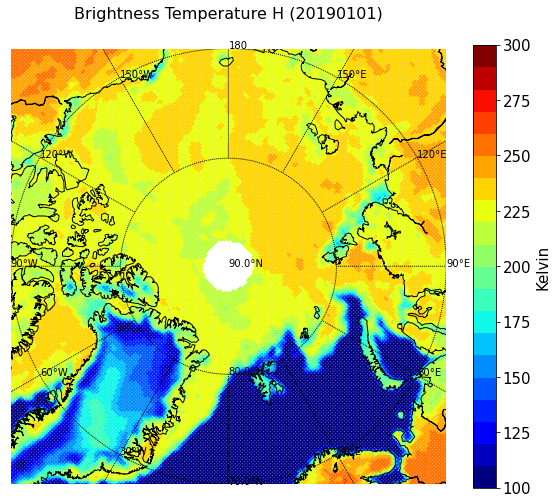

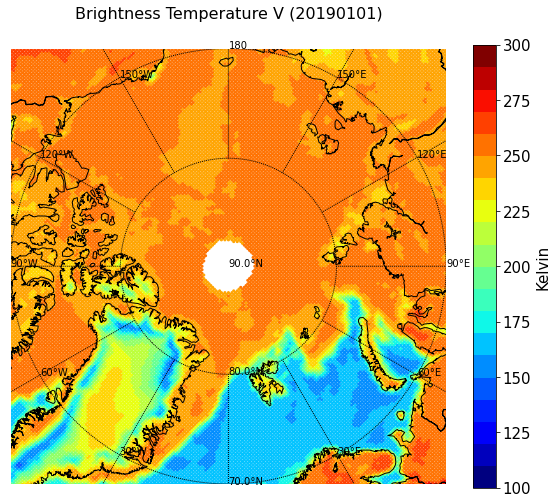

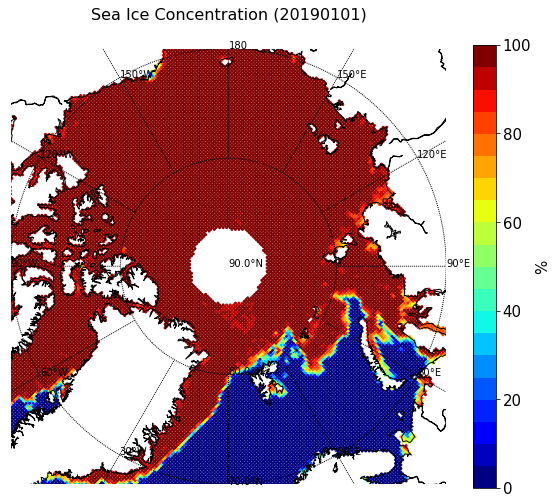

In [7]:
def PolarStereoMap(data0, lons, lats, min, max, levels, title, cbartitle): 
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    
    data = data0.copy()
    data[np.where(data > max)] = max
    data[np.where(data < min)] = min
    
    boundinglat = 70
    lon_0 = 0
    
    m = Basemap(projection='npstere', resolution = 'l',\
                boundinglat=boundinglat,lon_0=lon_0)
    x, y = m(lons, lats)
    
    fig = plt.figure(figsize=(8,7))
    m.drawcoastlines()    # 해안선 그리기
    m.drawmeridians(np.arange(0,360,30),thick=20,latmax=80)    # 경도선 그리기
    m.drawparallels([60,70,80],thick=20)                       # 위도선 그리기
    m.drawmapboundary(color='none')
    cs = m.scatter(x, y, c=data, s=4, cmap=plt.cm.get_cmap('jet', levels), vmin = min, vmax = max)
    
    # 위도 라벨 표시
    latlabels=[]
    lons_latlabel = [0] * 3
    lats_latlabel = np.arange(3) * 10. + boundinglat
    for templat in lats_latlabel:
        latlabels.append(str(templat) + '°N')
    xx, yy, =m(lons_latlabel, lats_latlabel)
    for label, xpt, ypt in zip(latlabels, xx, yy):
        plt.text(xpt, ypt, label)
    
    # 경도 라벨 표시
    lonlabels = []
    lons_lonlabel = np.array([30,60,90,120,150,180,-150,-120,-90,-60,-30])
    lats_lonlabel = [boundinglat]*11
    for templon in lons_lonlabel:
        if templon > 0 and templon <180:
            lonlabels.append(str(templon) + '°E')
        if templon == 180:
            lonlabels.append(str(templon))
        if templon < 0:
            lonlabels.append(str(-templon) + '°W')
    xx, yy, =m(lons_lonlabel, lats_lonlabel)
    for label, xpt, ypt in zip(lonlabels, xx, yy):
        plt.text(xpt, ypt, label)
    
    plt.title(title, pad=30, fontsize=16)      # 그림 제목
    cbar = plt.colorbar(cs)                    
    cbar.ax.set_ylabel(cbartitle, fontsize=15) # 컬러바 제목
    cbar.ax.tick_params(labelsize=15)          
    cbar.set_clim(min,max)                     # 컬러바 최대, 최소
    plt.tight_layout()
    
    plt.show()

PolarStereoMap(TBH, lons, lats, 100, 300, 20, 'Brightness Temperature H (20190101)', 'Kelvin')
PolarStereoMap(TBV, lons, lats, 100, 300, 20, 'Brightness Temperature V (20190101)', 'Kelvin')
PolarStereoMap(SIC, lons, lats, 0, 100, 20, 'Sea Ice Concentration (20190101)', '%')

### 해빙 점유율 자료를 사용하여 SIE 시계열 그리기

* SIE(Sea Ice Extent): 해빙 점유율이 15% 이상인 격자들의 면적

* import glob ?

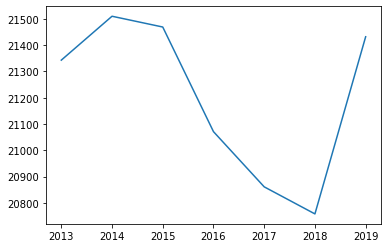

In [8]:
import numpy as np
import h5py

###---SIC 자료 읽는 함수 정의
def readSIC(filename):
    fSIC = h5py.File(filename, 'r')
    SIC = np.array(fSIC['Geophysical Data'])*0.1
    SIC = SIC[:,:,0]
    SIC[np.where(SIC <0)] =np.nan
    return(SIC)

###---SIC 시계열 파일명을 리스트로 저장
import glob
file_list_SIC = glob.glob('./data/SIC/*')

###---파일을 하나씩 읽은 뒤 SIC>15% 이상인 격자 수를 세어 저장
SIE_series = []
for i in range(len(file_list_SIC)):
    SIC = readSIC(file_list_SIC[i])
    spotSICgt15 = np.where(SIC >= 15)
    SIE = len(spotSICgt15[0])
    SIE_series.append(SIE)

###--- 시계열 
import matplotlib.pyplot as plt
years = np.arange(2013, 2020)
plt.plot(years, SIE_series)

---
## 2-2 위성관측 밝기온도로부터 해빙방출률 산출하기

---
### 1) 이론 설명
### 2) 수평/수직 편광밝기온도를 사용한 해빙방출률 계산 함수 작성
### 3) 작성한 함수를 위성관측자료에 적용
### 4) 결과 표출
---

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


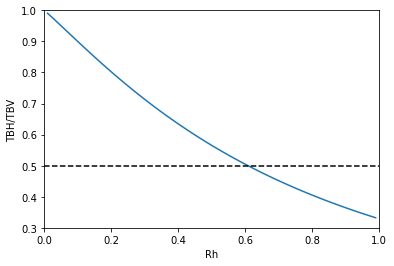

In [9]:
import numpy as np
def CombFresEq(Rh, theta): # Combined Fresnel equation
    cos = np.cos(2. * np.deg2rad(theta))
    Rv = (Rh**2.) * ( (1.+cos/np.sqrt(Rh)) / (1.+cos*np.sqrt(Rh)) )**2.
    return(Rv)

Rh = np.arange(0,1.01, 0.01)
ratio = (1.-Rh)/(1.-CombFresEq(Rh, 55.))

ratio_sample = 0.5

import matplotlib.pyplot as plt
plt.plot(Rh, ratio)
plt.plot([0,1], [ratio_sample]*2, 'k--')
plt.xlim(0,1)
plt.ylim(0.3,1)
plt.xlabel('Rh')
plt.ylabel('TBH/TBV')
plt.show()

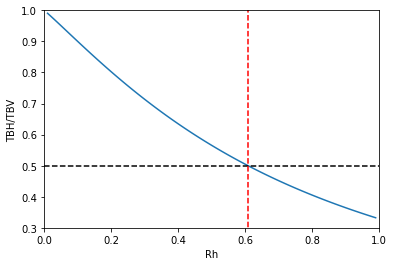

In [10]:
def solver(c, theta):
    Rh_now = 0.5
    Rh_0 = 0.0001
    Rh_1 = 0.9999
    while True:
        c_now = (1.-Rh_now)/(1.-CombFresEq(Rh_now, theta))
        if abs(c_now-c)<0.0001:
                return(Rh_now)
                break
        else :
            if c_now-c > 0.:
                Rh_0 = Rh_now
                Rh_1 = Rh_1
                Rh_now = (Rh_now+Rh_1)/2.
            else :
                Rh_0 = Rh_0
                Rh_1 = Rh_now
                Rh_now = (Rh_now+Rh_0)/2.

Rh_solution = solver(ratio_sample, 55)
plt.plot(Rh, ratio)
plt.plot([0,1], [ratio_sample]*2, 'k--')
plt.plot([Rh_solution]*2, [0,1], 'r--')
plt.xlim(0,1)
plt.ylim(0.3,1)
plt.xlabel('Rh')
plt.ylabel('TBH/TBV')
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


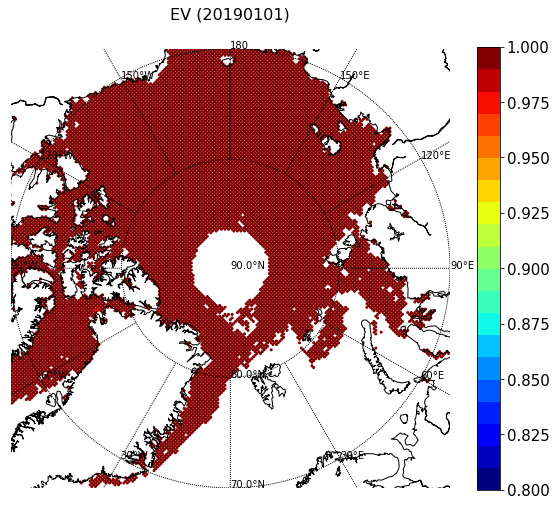

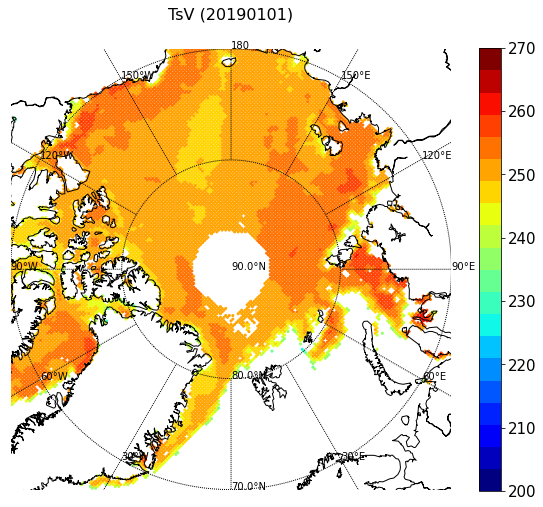

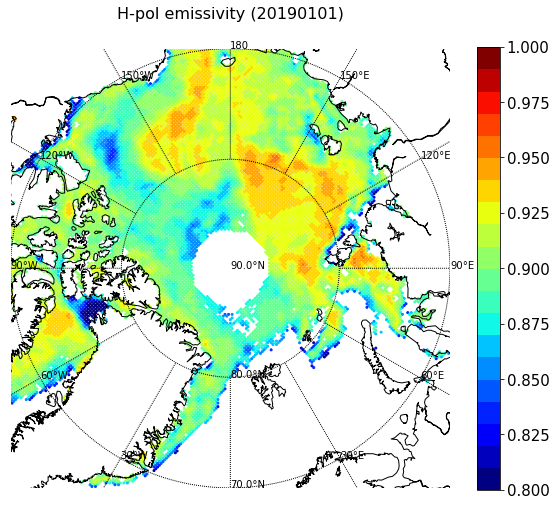

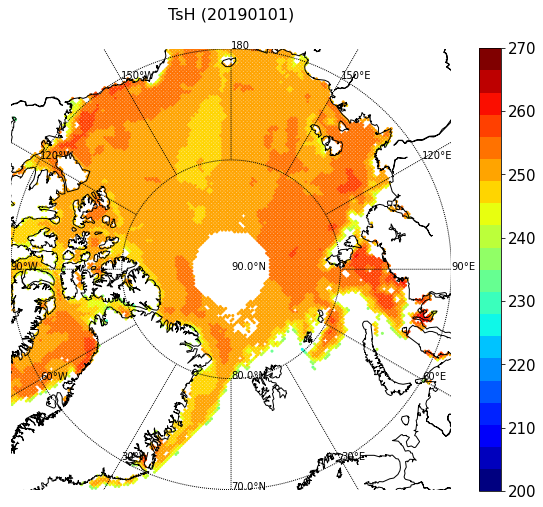

In [11]:
ratios = TBH/TBV
RH = np.zeros((448,304)) * np.nan
for i in range(448):
    for j in range(304):
        ratio = ratios[i,j]
        if (np.isfinite(ratio)) & (SIC[i,j] >= 95):
            RH[i,j] = solver(ratio, 55)

RV = CombFresEq(RH, 55.)

EV = 1. - RV
EH = 1. - RH

Ts_H = TBH/EH
Ts_V = TBV/EV

PolarStereoMap(EV, lons, lats, 0.8, 1, 20, 'EV (20190101)', '')
PolarStereoMap(Ts_V, lons, lats, 200, 270, 20, 'TsV (20190101)', '')
PolarStereoMap(EH, lons, lats, 0.8, 1, 20, 'H-pol emissivity (20190101)', '')
PolarStereoMap(Ts_H, lons, lats, 200, 270, 20, 'TsH (20190101)', '')

---
## 2-3. ICESat-2

---
### 1) ICESat-2 freeboard 자료 읽고 표출하기
### 2) 25 km polar stereographic grid 에서 track 자료의 위경도와 가장 가까운 위치 찾기
### 3) track 자료를 grid 자료로 변환
### 4) 결과 표출
---

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


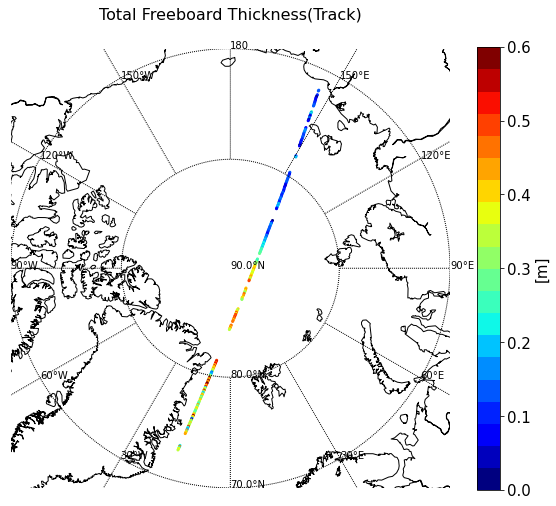

In [13]:
import numpy as np
import h5py 

def readIS2(fileIS2):
    f = h5py.File(fileIS2, 'r')
    gt1l = f['gt1l/freeboard_beam_segment']
    htf1l = np.array(gt1l['beam_fb_height'])
    htf1l[np.where(htf1l > 100)] = np.nan
    lon1l = np.array(gt1l['longitude'])
    lat1l = np.array(gt1l['latitude'])
    return(lon1l, lat1l, htf1l)
    
filename_IS2 ='./data/ICESat-2/ATL10-01_20190101005132_00550201_002_01.h5'
lons_sat, lats_sat, htfs_sat = readIS2(filename_IS2)

def ReadCoordinate(filename):
    f = open(filename, 'rb')
    value = np.fromfile(f, dtype = np.int32)
    value = value.reshape(448, 304)
    value = value * 1e-5
    return(value)

fileLon = './data/psn25lons_v3.dat'
fileLat = './data/psn25lats_v3.dat'
lons_grid = ReadCoordinate(fileLon) 
lats_grid = ReadCoordinate(fileLat) 

PolarStereoMap(htfs_sat, lons_sat, lats_sat, 0, 0.6, 20, 'Total Freeboard Thickness(Track)', '[m]')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


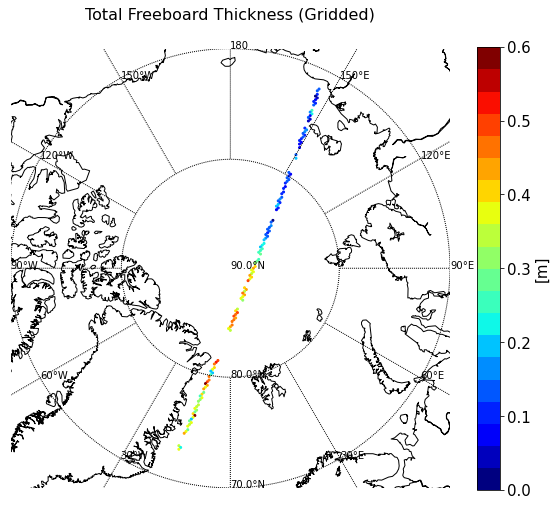

In [14]:
lons_sat_rad = np.radians(lons_sat)
lats_sat_rad = np.radians(lats_sat)
lons_grid_rad = np.radians(lons_grid)
lats_grid_rad = np.radians(lats_grid)

Re = 6371.228 #km

total = np.zeros((448,304))
count = np.zeros((448,304))

for i in range(len(htfs_sat)):
    htf0 = htfs_sat[i]
    if np.isfinite(htf0) == 0:
        continue
    
    lon0_rad = lons_sat_rad[i]
    lat0_rad = lats_sat_rad[i]
    
    havs_lat = np.sin((lats_grid_rad - lat0_rad)/2.)**2.
    havs_lon = np.sin((lons_grid_rad - lon0_rad)/2.)**2.
    dist_array = 2.*Re*np.arcsin(np.sqrt(havs_lat + np.cos(lats_grid_rad)*np.cos(lat0_rad) * havs_lon))
    
    spot = np.where(dist_array == np.nanmin(dist_array))
    x0 = spot[0][0]
    y0 = spot[1][0]
    dist0 = dist_array[spot]
    
    if dist0 > np.sqrt(12.5*12.5+12.5*12.5):
        continue
    total[spot] = total[spot] + htf0
    count[spot] = count[spot] + 1.
                
htfs_grid = total/count
PolarStereoMap(htfs_grid, lons_grid, lats_grid, 0, 0.6, 20, 'Total Freeboard Thickness (Gridded)', '[m]')